# Tutorial 4 - ML Classification Workflow

In this tutorial we will be working through the process of training a Stochastic Gradient Descent (SGD) Classifier to classify data points from a dataset. For this walkthough, we will be using the *breast cancer wisconsin dataset* that is available within scikit-learn. This dataset is more complex than many of the previous data sets as it contains 30 features.

We will follow the same general workflow as the example:

1. Load and split the data into test and train sets.
2. Standardise the data for use within the SGD Classifier.
3. Train and cross-validate the classifier to check that the model fits the training data - we will extend this to select the top performing pair of features.
4. Calculate a confusion matrix and test metrics across the test dataset.
5. Generate a ROC curve and calculate the Area-Under-Curve (AUC) for the test set.
6. Visualise the classification on the test set to understand the results.


As always we will start by importing all of the libraries and modules that we will need.


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc

Now we can import the dataset and extract the *data* and *target* fields.

In [26]:
data_set = load_breast_cancer()

X = data_set.data
y = data_set.target
nclasses = len(data_set.target_names)
data_set.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

## Exercise for you
**Your first task** will be to implement the split between the *test* and *training* sets. The training set will be used for training and feature selection through a process of cross-validation. You will need to use the ```train_test_split( ... )``` function to achieve this 

In [27]:
# Split the data into a training set and a test set. It would be a good idea to explicly stratify this set.
X_train, X_test, y_train, y_test = train_test_split(X, y)



The Stochastic Gradient Descent (SGD) Classifier (and the SVM that sits within) is sensitive to the *scale* of the features. (i.e. the range of the features affects how well they can be used for classification). We will standardize each of the features so that they have mean of 0 and a standard deviation of 1: 

In [28]:
# Standardize
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std

Now we can do some feature selection. In this example we will select the best 2 features based upon the results of a cross-validation. We will use the mean F1 score as the measure for our cross-validation performance to select the best combinations of features:
1. We will implement this using a set of nested loops that will select each combination of features for cross validation. 
2. We can then use ```cross_val_predict( ... )```  to produce some predicted results for the training dataset. 
3. We can then produce a confusion matrix to calculate some performance metrics.

## Exercise for you

**Your next task** will be to implement the training, cross validation and calculation of the performance metrics within the nested loop. Fill in the sections indicated by the `???` markers.


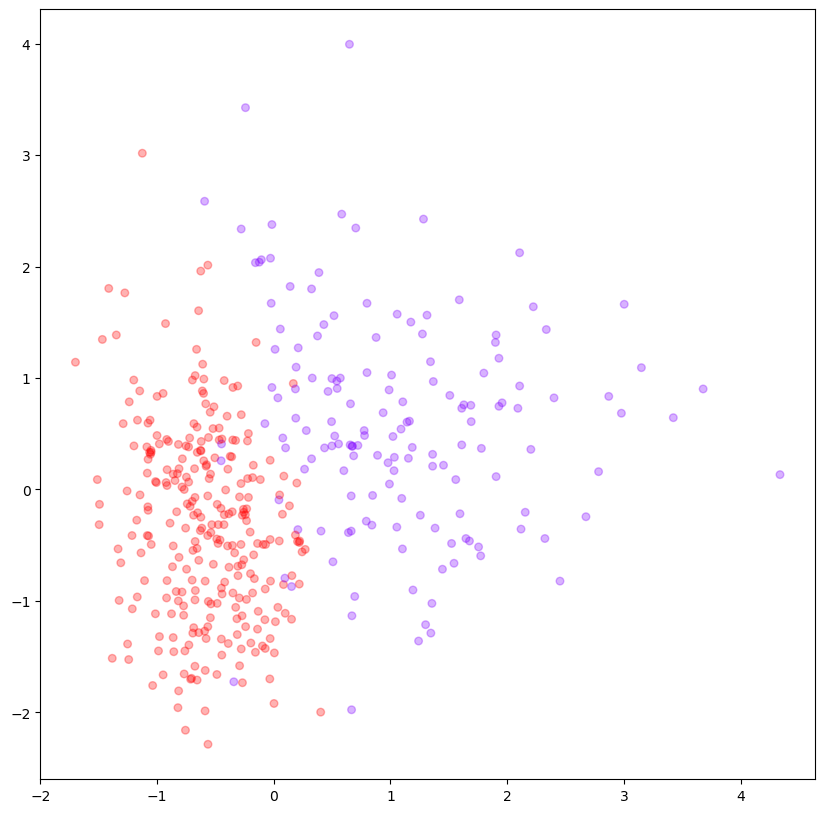

In [31]:
#We need to store the best performance and the features that achieved them.
best_mean_f1 = 0
best_f1 = 0
best_f2 = 0

# We will be testing every combination of pairs of features 

for f1 in range(0,30):
    for f2 in range(0,30):
        
        # We want 2 features, not 1
        if f1 == f2:
            continue
        
        features_idx_to_use = [f1,f2]
        
        clf = SGDClassifier( random_state = 42 )         #COMPLETE
        clf.fit(X_train[:, features_idx_to_use], y_train)   #COMPLETE
        
        # Return the predictions for the 3-Fold crossvalidation
        
        y_predicted = cross_val_predict(clf, X_train[:,features_idx_to_use ], y_train, cv=3 ) #COMPLETE
        
        # Construct the confusion matricies
        conf_mat_train = confusion_matrix( y_train, y_predicted ) #COMPLETE
        
        # Print out the recall, precision and F1 scores
        # There will be a value for each class
        # CV Train
        # print("CV Train:",f1,":",f2," - ", recall_score( y_train, y_predicted))  #COMPLETE
        # print("CV Train:",f1,":",f2," - ",precision_score( y_train, y_predicted)) #COMPLETE
        # print("CV Train:",f1,":",f2," - ",f1_score( y_train, y_predicted)   )     #COMPLETE

        # Now we need to store the result 
        current_f1 = np.mean(f1_score( y_train, y_predicted, average=None)) #COMPLETE
        if current_f1 > best_mean_f1:
            best_f1 = f1
            best_f2 = f2
            best_mean_f1 = current_f1
            best_clf = clf
              
# Plot the best performing features to visualise them. This will allow us to
# sanity check our cross validation.              
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(X_train[:,best_f1], X_train[:,best_f2], c=y_train, cmap='rainbow', alpha=0.3, s=30)

Once you have completed the cross-validation and identified the best combination features to use, it is time to run your trained classifier (```best_clf```), across the test set. You will need to construct a confusion matrix and calculate the performance metrics for the test set.

## Exercise for you

**Your next task** will be to:

1. Apply the standardization to the test set using the mean and standard deviation from the training set.
2. Construct a confusion matrix for prediction on the test data set.
3. Calculate and print the performance metrics (F1, recall and precision)

In [32]:
# Now we need to test our classifier using the test set.
# Recall that we standardised the data - we need to do the same with the stored
# Mean and standard deviation from the training set.
X_test = (X_test - mean) / std

y_test_predicted = best_clf.predict(X_test[:,[best_f1, best_f2]])
conf_mat_test = confusion_matrix(y_test, y_test_predicted)

# Test
print("Test:",recall_score( y_test, y_test_predicted))
print("Test:",precision_score( y_test, y_test_predicted))
print("Test:",f1_score( y_test, y_test_predicted)) 

Test: 0.9397590361445783
Test: 0.6190476190476191
Test: 0.7464114832535885


Now we can build a ROC curve for the predictions on the test data set. We will also calculate the AUC of the ROC curve. 

## Exercise for you

**Your next task** will be to:

1. Calculate the scores using the `decision_function( ... )` function on your best classifier.
2. Calculate the true-positive-rate and false-positive-rate using the `roc_curve( ... )` function.
3. Calculate the AUC value using the `auc( ... )` function.
       

In [37]:
y_score = best_clf.decision_function(X_test[:, [best_f1, best_f2]])

# We need to format the y_test into a n_samples x 2 binary array
# that indicates class membership
# y_test_bin = label_binarize(y, classes=[0, 1])
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_test, y_score )
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)

AUC: 0.7433734939759037


Now we can plot the ROC curve. Nothing for you to do here!

In [ ]:
# Plot the TPR vs FPR for each class
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(fpr, tpr, color='orange')
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic Curve')
ax.legend(loc="lower right")

The final task we have to complete is to plot the decision boundary and the test data points so that we can better understand the results that we have recieved. We have seen several examples of this process: first we need to construct a mesh-grid, then classify each point within the mesh. Lets start by creating our mesh-grid.

## Exercise for you

**Your next task** will be to:
1. Set the minimums and maximums for the grid using the `best_f1` and `best_f2` features from the test dataset.

In [39]:
h = .02  # step size in the mesh
# create a mesh to plot in
x_min, x_max = X_test[:, best_f1].min() - 1, X_test[:, best_f1 ].max() + 1
y_min, y_max = X_test[:, best_f2].min() - 1, X_test[:, best_f2].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))




Next we can perform the classification on the points within the mesh so that we can plot the classification regions.

## Exercise for you

**Your next task** will be to:

1. Classify each point in the mesh grid
2. plot this mesh using the `contourf( ... )` function.

You will need to check the examples for the code to use in this section.

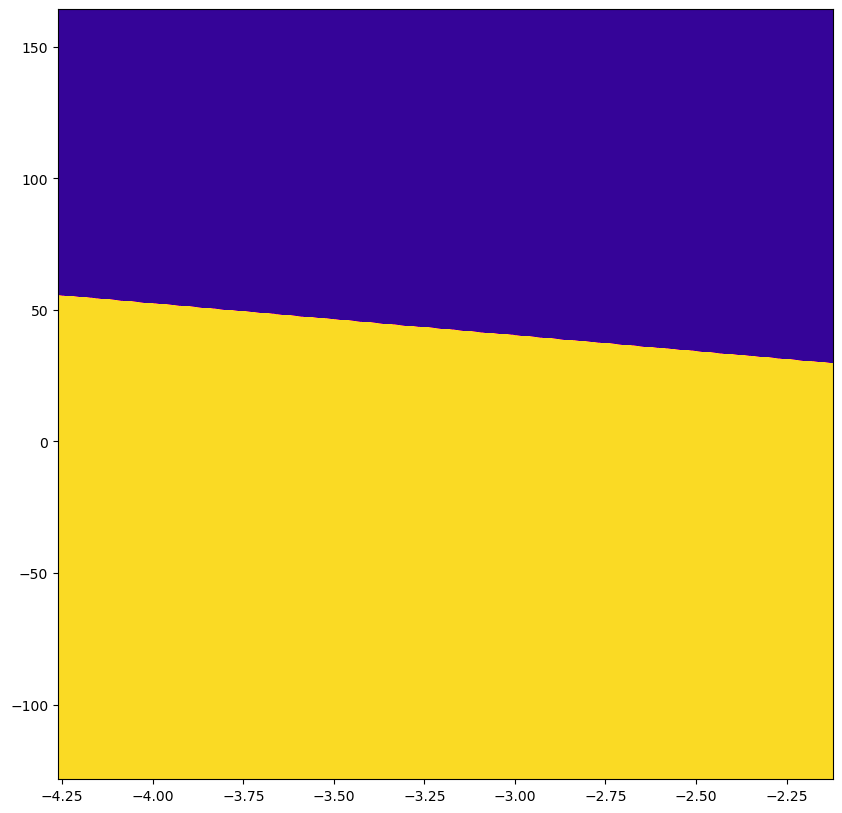

In [40]:
fig, ax = plt.subplots(figsize=(10,10))

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
Z = best_clf.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)
cs = ax.contourf(xx, yy, Z,cmap=plt.get_cmap('plasma'))

Now we are ready to plot the test data points on top of the contour plot. We will finish up by plotting the hyperplane from the SVM using the information from the classifier. This should match the boundary of the classification regions within the grid.

Nothing for you to do here!

C:\Users\Hahn\AppData\Local\Temp\ipykernel_11052\3001379014.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_test[idx, best_f1], X_test[idx, best_f2], c=color, label=data_set.target_names[i],


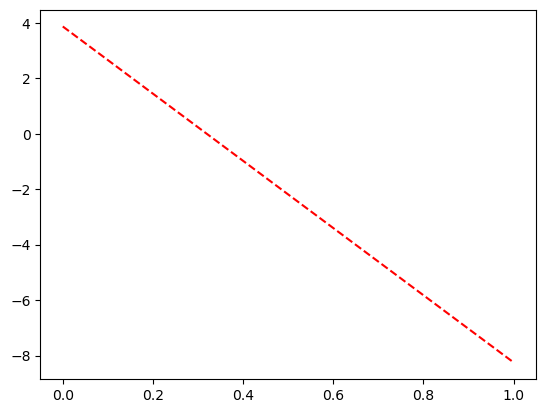

In [41]:
colors = ['cyan','orange']
# Plot also the training points
for i, color in zip(best_clf.classes_, colors):
    idx = np.where(y_test == i)
    ax.scatter(X_test[idx, best_f1], X_test[idx, best_f2], c=color, label=data_set.target_names[i],
                cmap=plt.get_cmap('plasma'), edgecolor='black', s=20)
ax.set_title("Decision surface of Binary SGD")
ax.axis('tight')

xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
coef = best_clf.coef_
intercept = best_clf.intercept_

# Lets make a function to plot the hyperplanes used by the SVM for 
# Classification.

def plot_hyperplane(c, color):
    def line(x0):
        return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]

    plt.plot([xmin, xmax], [line(xmin), line(xmax)],
              ls="--", color=color)

plot_hyperplane(0, "red")